# Описание проекта

# Определение региона, где добыча нефти принесет наибольшую прибыль


## Данные

В наличии имеются данные с трех регионов, в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов

## Задача
Решить в каком регионе добывать нефть. Построить модель машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль с наименьшим риском убытков.

## Навыки и инструменты
*Pandas, sklearn, math, numpy, Seaborn, Matplotlib, SciPy, Bootstrap, машинное обучениеb*

## Описание проекта
Собраны характеристики пробы нефти для скважин: качество нефти и объём её запасов по трем регионам. Характеристики для каждой скважины в регионе уже известны. 
Построена модель для предсказания объёма запасов в новых скважинах.
Выбраны скважины с самыми высокими оценками значений.
Определены регионы с максимальной суммарной прибылью отобранных скважин.
Построена модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализирована возможная прибыль и риски техникой Bootstrap.

In [6]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
from sklearn import tree
from sklearn.model_selection import cross_val_score
import seaborn as sns
import math
import calendar
from scipy import stats as st
from math import factorial
pd.set_option('display.max_columns', 100)# можно не 100, а none
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import classification_report
#import mglearn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures

In [7]:
#Заблокируем предупреждения
import warnings
warnings.filterwarnings('ignore')

# 1. Загрузка и подготовка данных

Загрузим данные

In [8]:
region_1 = pd.read_csv("geo_data_0.csv")
region_2 = pd.read_csv("geo_data_1.csv")
region_3 = pd.read_csv("geo_data_2.csv")


## Посмотрим на данные для region_1

In [9]:
region_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Посмотрим информацию о таблице

In [10]:
region_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Посчитаем количество столбцов с данными каждого типа 

In [11]:
region_1.dtypes.value_counts()

float64    4
object     1
dtype: int64

Таблица содержит данные о скважинах в регионе 1 и состоит из 100000 строк и 5 столбцов. 4 столбца представлены вещественными числами, один - строками.

Посмотрим на уникальные значения в каждом столбце

In [12]:
region_1.apply(pd.Series.nunique, axis = 0)

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Видим, что есть 10 скважин с задублированными названиями. Но данные по ним разные. Посмотрим на эти скважины.

In [13]:
print(region_1[region_1.duplicated(subset='id', keep='first')].id)

7530     HZww2
41724    bxg6G
51970    A5aEY
63593    QcMuo
66136    74z30
69163    AGS9W
75715    Tdehs
90815    fiKDv
92341    TtcGQ
97785    bsk9y
Name: id, dtype: object


Понятно, что 10 строк из 100000 большого значения не играют. Удалим их.

In [15]:
region_1 = region_1.drop_duplicates(subset ="id").reset_index(drop=True)
region_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Посмотрим, остались ли дубликаты

In [16]:
region_1.apply(pd.Series.nunique, axis = 0)

id         99990
f0         99990
f1         99990
f2         99990
product    99990
dtype: int64

Видим, что дубликатов нет и пропусков тоже. Таблица готова для дальнейшей работы.

Посмотрим на характер распределения данных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000150302C8>,
      dtype=object)

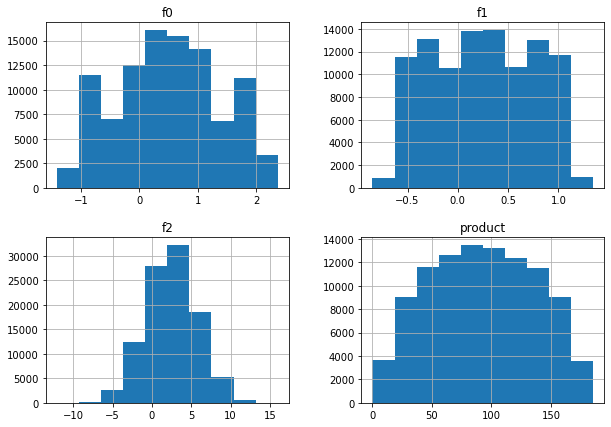

In [17]:
region_1.hist(bins = 10, figsize = (10, 7))

Видим нормальное распределение. Увеличим количество корзин.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000143A1648>,
      dtype=object)

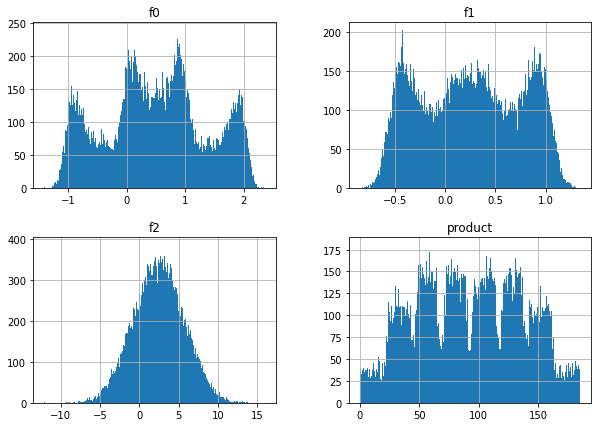

In [18]:
region_1.hist(bins = 1000, figsize = (10, 7))

Видим, что данные распределены симметрично, выбросов нет. Первые два графика (верхний ряд) говорят о том, что есть несколько видов нефти по определенному качественному признаку. И внутри каждого вида нефти распределение нормальное. Наслаиваясь друг на друга, они образуют такую волнообразную картину. Признак f2 не зависит от качества нефти и просто нормально распределяется среди всех скважин. График объемов запаса нефти говорит о том, что скважины имеют четкую сегментацию по объему нефти в них. Каждый сегмент отличается от предыдущего на 50 тыс. баррелей. Скоорее всего это связано со способом определения объема нефти, когда при определенных данных измерений (геология, геофизика, химия и т.п.) каждая скважина относится к определеному типу и примерно определяется объем этой скважины в соответсвии с типом. и таких "объемных" типов скважин мы видим 8. Внутри каждого из них распределение нормальное. А аппроксимируя их, также получаем нормальное распределение.

Посмотрим сводную статистическую информацию по всей таблице.

In [19]:
region_1.describe()

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


Ничего особого не видим, за исключение значения объема "0" в одной скважине, но она всего одна и причин указать в ней 0 может быть масса (ошибка, выкачали, очень мало и т.п.)

## Посмотрим на данные для region_2

In [20]:
region_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Посмотрим информацию о таблице

In [21]:
region_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Посчитаем количество столбцов с данными каждого типа 

In [22]:
region_2.dtypes.value_counts()

float64    4
object     1
dtype: int64

Таблица содержит данные о скважинах в регионе 2 и состоит из 100000 строк и 5 столбцов. 4 столбца представлены вещественными числами, один - строками.

Посмотрим на уникальные значения в каждом столбце

In [23]:
region_2.apply(pd.Series.nunique, axis = 0)

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

Видим, что есть 4 скважины с задублированными названиями. Но самое интересное, что количество нефти среди 100000 скважин распределилось всего по 12 значениям. Посмотрим на дубли id и product         

In [24]:
print(region_2[region_2.duplicated(subset='id', keep='first')].id)

41906    LHZR0
82178    bfPNe
82873    wt4Uk
84461    5ltQ6
Name: id, dtype: object


Понятно, что 4 строки из 100000 большого значения не играют, но для учебных целей удалим их.

In [25]:
region_2 = region_2.drop_duplicates(subset ="id").reset_index(drop=True)
region_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Посмотрим, остались ли дубликаты в столбце id

In [26]:
region_2.apply(pd.Series.nunique, axis = 0)

id         99996
f0         99996
f1         99996
f2         99996
product       12
dtype: int64

Видим, что дубликатов нет и пропусков тоже.

Посмотрим на уникальные значения в столбце product

In [27]:
region_2["product"].value_counts()

53.906522     8472
26.953261     8468
84.038886     8430
57.085625     8389
3.179103      8337
80.859783     8320
30.132364     8306
110.992147    8303
134.766305    8303
0.000000      8235
137.945408    8233
107.813044    8200
Name: product, dtype: int64

Видим примерно одинаковое распределение всех скважин между 12 "объемными" типами скважин. Т.е. гипотеза о неких "объемных" типах скважин и существовании некоего алгоритма, изборочно относящего скважины к этим типам, подтверждается. Только в первом регионе таких типов 8, а здесь 12.

Посмотрим на характер распределения данных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000019E3EB48>,
      dtype=object)

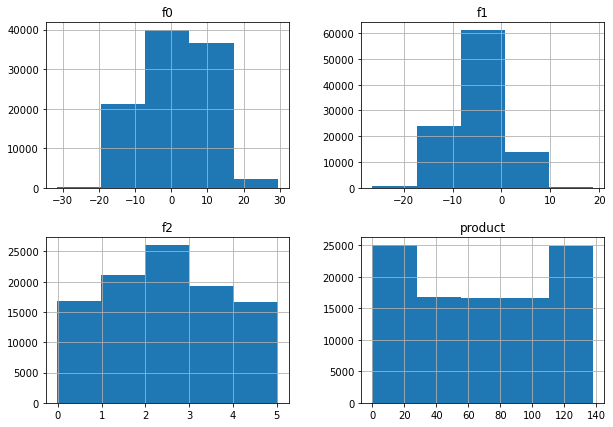

In [28]:
region_2.hist(bins = 5, figsize = (10, 7))

Видим нормальное распределение, за исключением последнего графика. Увеличим количество корзин.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001A34E848>,
      dtype=object)

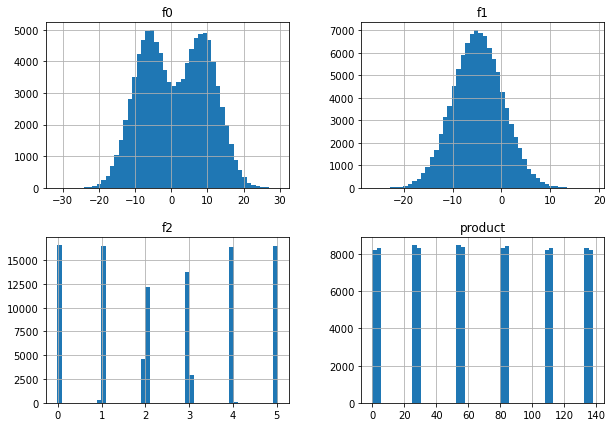

In [29]:
region_2.hist(bins = 50, figsize = (10, 7))

Видим, что данные распределены симметрично, выбросов нет. Первый график (f0) говорит о том, что есть два видов нефти по определенному качественному признаку. И внутри каждого вида нефти распределение нормальное. Наслаиваясь друг на друга, они образуют такую волнообразную картину. Признак f1 не зависит от качества нефти и просто нормально распределяется среди всех скважин. Глядя на нижние графики, мы понимаем, что главным критерием сегментации скважин на  "объемные" типы явялется показатель f2. Этот признак делится на 6 больших групп, и объем скважин также делится на 6 групп, сгруппироанных по 2, итого 12, как мы видели выше.

Посмотрим сводную статистическую информацию по всей таблице.

In [30]:
region_2.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Ничего особого не видим.

 Таблица готова для дальнейшей работы.

## Посмотрим на данные для region_3

In [31]:
region_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Посмотрим информацию о таблице

In [32]:
region_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Посчитаем количество столбцов с данными каждого типа 

In [33]:
region_3.dtypes.value_counts()

float64    4
object     1
dtype: int64

Таблица содержит данные о скважинах в регионе 3 и состоит из 100000 строк и 5 столбцов. 4 столбца представлены вещественными числами, один - строками.

Посмотрим на уникальные значения в каждом столбце

In [34]:
region_3.apply(pd.Series.nunique, axis = 0)

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Видим, что есть 4 скважины с задублированными названиями. Посмотрим на дубли id

In [35]:
print(region_3[region_3.duplicated(subset='id', keep='first')].id)

43233    xCHr8
49564    VF7Jo
55967    KUPhW
95090    Vcm5J
Name: id, dtype: object


Понятно, что 4 строки из 100000 большого значения не играют, но для учебных целей удалим их.

In [36]:
region_3 = region_3.drop_duplicates(subset ="id").reset_index(drop=True)
region_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Посмотрим, остались ли дубликаты в столбце id

In [37]:
region_3.apply(pd.Series.nunique, axis = 0)

id         99996
f0         99996
f1         99996
f2         99996
product    99996
dtype: int64

Видим, что дубликатов нет и пропусков тоже.

Посмотрим на характер распределения данных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001AFEEB88>,
      dtype=object)

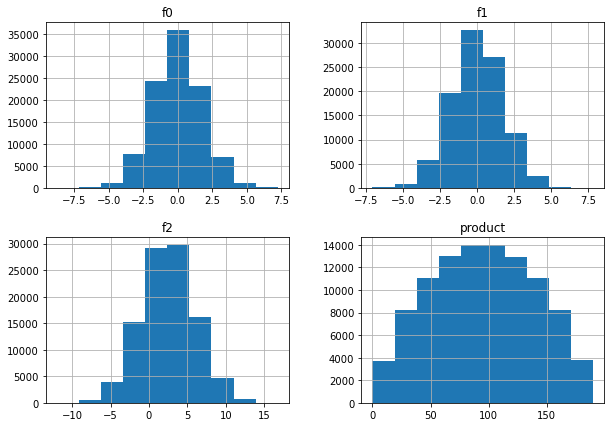

In [38]:
region_3.hist(bins = 10, figsize = (10, 7))

Видим нормальное распределение. Увеличим количество корзин.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001AA84648>,
      dtype=object)

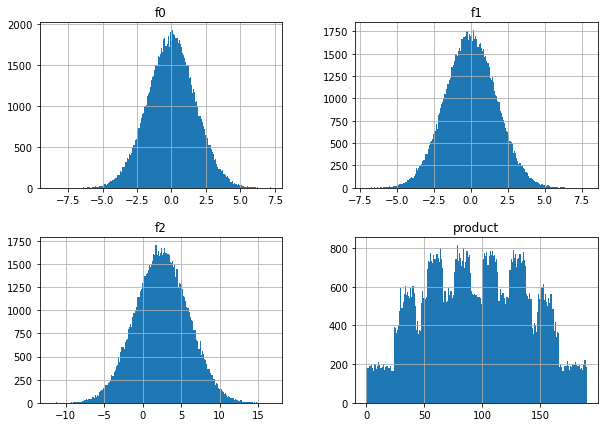

In [39]:
region_3.hist(bins = 200, figsize = (10, 7))

Картина похожая на первый регион, но здесь первые два признака также имеют нормадбное распредеение. И скважины по объему также делятся на 8 "объемных" типов.

Посмотрим сводную статистическую информацию по всей таблице.

In [40]:
region_3.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


Ничего особого не видим.

 Таблица готова для дальнейшей работы.

## Подготовка данных для машинного обучения

### Подготовка данных для региона 1

Напишем функцию, которая разделит датасет каждого региона на обучающие данные и целевой признак, а  затем сформирует обучающий и тестовый наборы данных отдельно для обучающей и валидационной выборок. После чего проведет маштабирование численных признаков с помощью MinMaxScaler. StandardScaler дает аналогичный результат при работе моделей.

In [41]:
def prepare_data(region):
    target = region['product']
    features = region.drop(['product', 'id'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
        target, test_size=0.25, random_state=12345)
   
    numeric = ['f0', 'f1', 'f2']
    scaler = MinMaxScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid

In [42]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = prepare_data(region_1)

### Подготовка данных для региона 2

In [43]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = prepare_data(region_2)

### Подготовка данных для региона 3

In [44]:
features_train_3, features_valid_3, target_train_3, target_valid_3 = prepare_data(region_3)

### <font color='red'>Вопрос ревьюеру: Я думал об этом, но у меня здесь генерируются разные названия переменных, например features_valid_1 и features_valid_2, которые получаются одинаковым образом просто из разных выборок. И я никак не придумаю как в цикле или в функции менять названия переменных, что бы функция на вход получала выборки, а возвращала разные названия пременных для разных выборок. Не пойму как разные числа присоединить к названию переменной.

# 2. Обучение и проверка модели для каждого региона

## 2.1. Обучение и проверка модели для региона 1

Напишем функцию для обучения модели и вывода ее основных параметром и визуализации результатов предсказаний.

In [45]:
def model(features_train, target_train, features_valid, target_valid, region):
    LR = LinearRegression() 
    LR.fit(features_train, target_train)
    global predictions
    predictions = LR.predict(features_valid)
    result = mean_squared_error(target_valid, predictions)
    print("RMSE для линейной регрессии:", result**0.5)
    print("R^2 для линейной регрессии: {:.2f}".format(LR.score(features_valid, target_valid)))
    print("MAE для линейной регрессии:", mean_absolute_error(target_valid, predictions))
    print("Средний запас сырья - истинное значение:", region['product'].mean())
    print("Средний запас сырья - предсказанное значение:", predictions.mean())
    print("Разница истинных и предсказанных значений запасов сырья:", region['product'].mean() - predictions.mean())
    print()
    pd.Series(predictions).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Предсказания модели")
    target_valid.reset_index(drop=True).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Истинные значения")
    plt.legend(loc="best")
    plt.show()

Применим функцию для обучения модели и вывода ее основных параметром и визуализации результатов предсказаний.

RMSE для линейной регрессии: 37.853527328872964
R^2 для линейной регрессии: 0.27
MAE для линейной регрессии: 31.141028675220266
Средний запас сырья - истинное значение: 92.49968421774328
Средний запас сырья - предсказанное значение: 92.78915638280621
Разница истинных и предсказанных значений запасов сырья: -0.28947216506293216



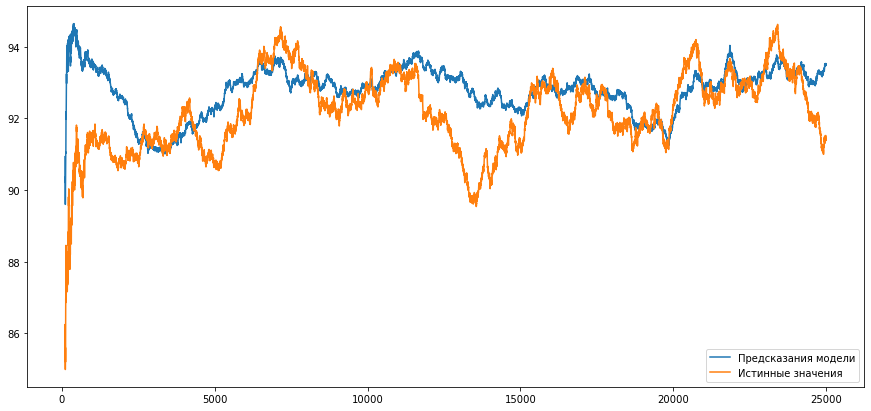

In [46]:
model(features_train_1, target_train_1, features_valid_1, target_valid_1, region_1)

Неплохие результаты, но в учебных целях попробуем их улучшить. Проведем полиномизацию обучающих признаков.

In [47]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=7, include_bias=False)
features_train_1_poly = poly.fit_transform(features_train_1)
features_valid_1_poly = poly.fit_transform(features_valid_1)

Посмотрим работу модели на полиномизированных данных

In [48]:
def model_2(result, features_train_poly, target_train, features_valid_poly, target_valid, region):
    if result == 1:
        global predictions_poly
        LR = LinearRegression() 
        LR.fit(features_train_poly, target_train)
        predictions_poly = LR.predict(features_valid_poly)
        result = mean_squared_error(target_valid, predictions_poly)
        print("RMSE для линейной регрессии:", result**0.5)
        print("R^2 для линейной регрессии: {:.2f}".format(LR.score(features_valid_poly, target_valid)))
        print("MAE для линейной регрессии:", mean_absolute_error(target_valid, predictions_poly))
        print("Средний запас сырья - истинное значение:", region['product'].mean())
        print("Средний запас сырья - предсказанное значение:", predictions_poly.mean())
        print("Разница истинных и предсказанных значений запасов сырья:", region['product'].mean() - predictions_poly.mean())
        print()
        pd.Series(predictions).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Предсказания модели")
        pd.Series(predictions_poly).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Предсказания модели на полиномах")
        target_valid.reset_index(drop=True).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Истинные значения")
        plt.legend(loc="best")
        plt.show()
    
    else:
        return predictions_poly

RMSE для линейной регрессии: 37.212913261032845
R^2 для линейной регрессии: 0.30
MAE для линейной регрессии: 30.61947338538191
Средний запас сырья - истинное значение: 92.49968421774328
Средний запас сырья - предсказанное значение: 92.67701466953238
Разница истинных и предсказанных значений запасов сырья: -0.17733045178910345



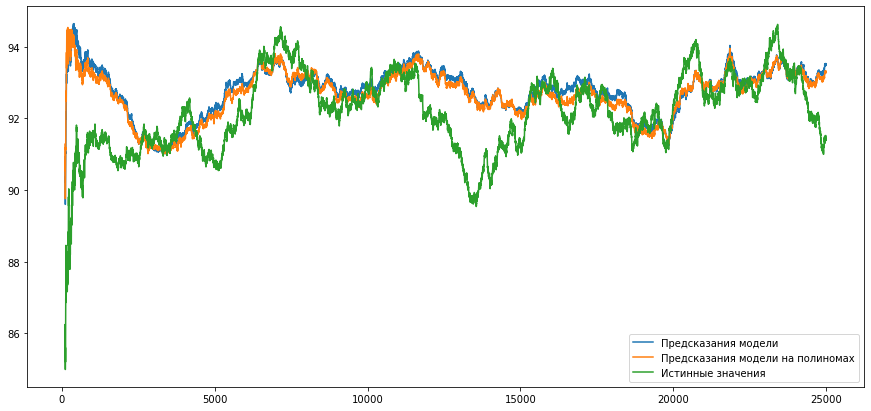

In [49]:
model_2(1, features_train_1_poly, target_train_1, features_valid_1_poly, target_valid_1, region_1)

Действительно, видим, что предсказания на полиномах расположены ближе к истинным значениям

### Сохраним предсказания и правильные ответы на валидационной выборке для региона 1

In [50]:
predictions_poly_1_1 = model_2(2, features_train_1_poly, target_train_1, features_valid_1_poly, target_valid_1, region_1)

In [51]:
region_1_data = pd.DataFrame([])
region_1_data["target"] = target_valid_1
region_1_data["predict"] = predictions_poly_1_1
region_1_data.head()

,target,predict
49466,123.566299,106.085233
55493,63.442039,76.205480
11689,88.718000,100.377435
13769,51.422060,101.620267
72389,102.569999,84.385513


## 2.2. Обучение и проверка модели для региона 2

Применим функцию для обучения модели и вывода ее основных параметром и визуализации результатов предсказаний.

RMSE для линейной регрессии: 0.8920592647717026
R^2 для линейной регрессии: 1.00
MAE для линейной регрессии: 0.7193530096516094
Средний запас сырья - истинное значение: 68.82391591806625
Средний запас сырья - предсказанное значение: 69.17831957030432
Разница истинных и предсказанных значений запасов сырья: -0.35440365223807646



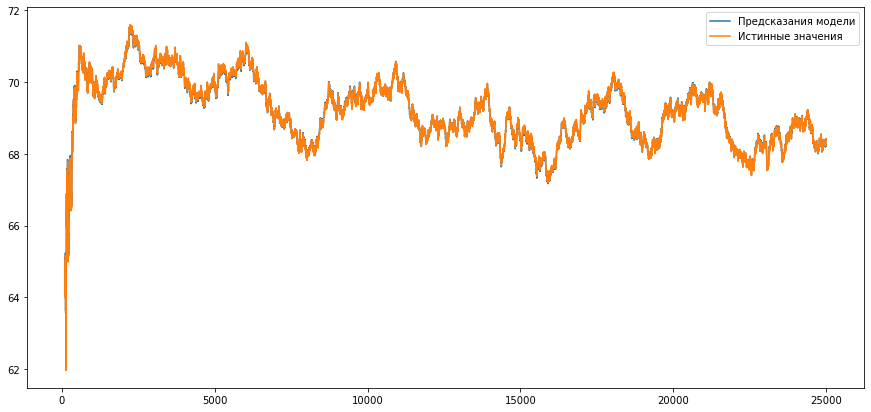

In [52]:
model(features_train_2, target_train_2, features_valid_2, target_valid_2, region_2)

Отличные предсказания. Разница с истинными значениями меньше миллиона. Проведем полиномизацию обучающих признаков.

In [53]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=9, include_bias=False)
features_train_2_poly = poly.fit_transform(features_train_2)
features_valid_2_poly = poly.fit_transform(features_valid_2)

RMSE для линейной регрессии: 0.7184235620895023
R^2 для линейной регрессии: 1.00
MAE для линейной регрессии: 0.37932094569126196
Средний запас сырья - истинное значение: 68.82391591806625
Средний запас сырья - предсказанное значение: 69.17883608502405
Разница истинных и предсказанных значений запасов сырья: -0.3549201669577968



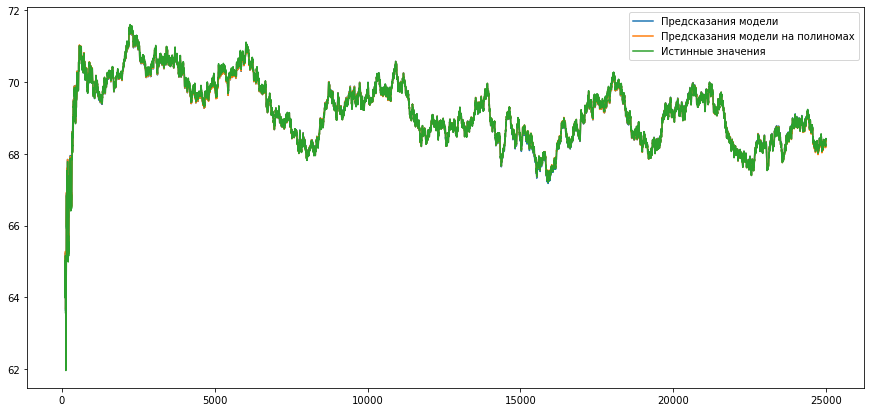

In [54]:
model_2(1, features_train_2_poly, target_train_2, features_valid_2_poly, target_valid_2, region_2)

Применим функцию для обучения модели и вывода ее основных параметром и визуализации результатов предсказаний.

### Сохраним предсказания и правильные ответы на валидационной выборке для региона 2

In [55]:
predictions_poly_2_2 = model_2(2, features_train_2_poly, target_train_2, features_valid_2_poly, target_valid_2, region_2)

In [56]:
region_2_data = pd.DataFrame([])
region_2_data["target"] = target_valid_2
region_2_data["predict"] = predictions_poly_2_2
region_2_data.head()

,target,predict
71747,53.906522,53.975719
80489,137.945408,137.963468
2655,30.132364,30.241102
71170,84.038886,83.855160
91137,0.000000,0.255288


## 2.3. Обучение и проверка модели для региона 3

In [57]:
LR = LinearRegression() 
LR.fit(features_train_3, target_train_3)
predictions = LR.predict(features_valid_3)
result = mean_squared_error(target_valid_3, predictions)
print("RMSE для линейной регрессии:", result**0.5)
print("R^2 для линейной регрессии: {:.2f}".format(LR.score(features_valid_3, target_valid_3)))
print("MAE для линейной регрессии:", mean_absolute_error(target_valid_3, predictions))
print("Средний запас сырья - истинное значение:", region_3['product'].mean())
print("Средний запас сырья - предсказанное значение:", predictions.mean())
print("Разница истинных и предсказанных значений запасов сырья:", region_3['product'].mean() - predictions.mean())

RMSE для линейной регрессии: 40.07585073246016
R^2 для линейной регрессии: 0.20
MAE для линейной регрессии: 32.83139014902301
Средний запас сырья - истинное значение: 94.99834211933415
Средний запас сырья - предсказанное значение: 94.86572480562035
Разница истинных и предсказанных значений запасов сырья: 0.13261731371380847


Визуализируем результаты предсказаний

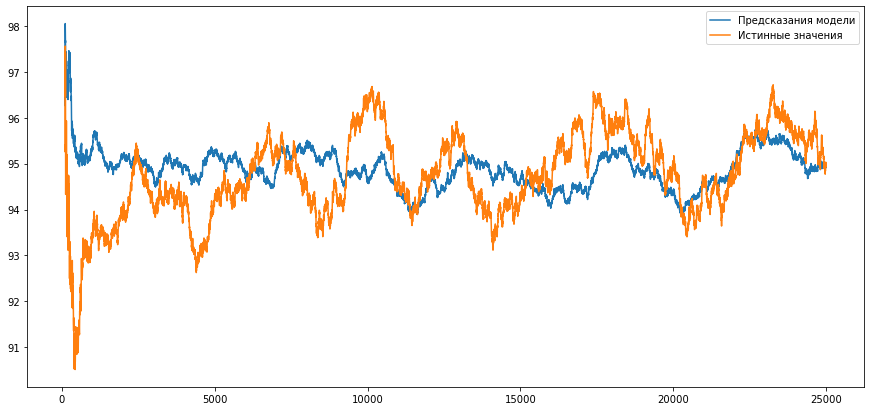

In [58]:
pd.Series(predictions).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Предсказания модели")
target_valid_3.reset_index(drop=True).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Истинные значения")
plt.legend(loc="best")

Неплохие предсказания. Проведем полиномизацию обучающих признаков.

In [59]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=8, include_bias=False)
features_train_3_poly = poly.fit_transform(features_train_3)
features_valid_3_poly = poly.fit_transform(features_valid_3)

In [60]:
features_train_3_poly.shape

(74997, 164)

In [61]:
LR_poly = LinearRegression() 
LR_poly.fit(features_train_3_poly, target_train_3)
predictions_poly_3 = LR_poly.predict(features_valid_3_poly)
result = mean_squared_error(target_valid_3, predictions_poly_3)
print("RMSE для линейной регрессии:", result**0.5)
print("R^2 для линейной регрессии: {:.2f}".format(LR_poly.score(features_valid_3_poly, target_valid_3)))
print("MAE для линейной регрессии:", mean_absolute_error(target_valid_3, predictions_poly_3))
print("Средний запас сырья - истинное значение:", region_3['product'].mean())
print("Средний запас сырья - предсказанное значение:", predictions_poly_3.mean())
print("Разница истинных и предсказанных значений запасов сырья:", region_3['product'].mean() - predictions_poly_3.mean())

RMSE для линейной регрессии: 38.103817180446995
R^2 для линейной регрессии: 0.27
MAE для линейной регрессии: 31.404038215745548
Средний запас сырья - истинное значение: 94.99834211933415
Средний запас сырья - предсказанное значение: 94.76234532037573
Разница истинных и предсказанных значений запасов сырья: 0.23599679895842485


Видим, что результаты несколько улучшились, но разница в запасах сырья увеличилась. Визуализируем результаты предсказаний

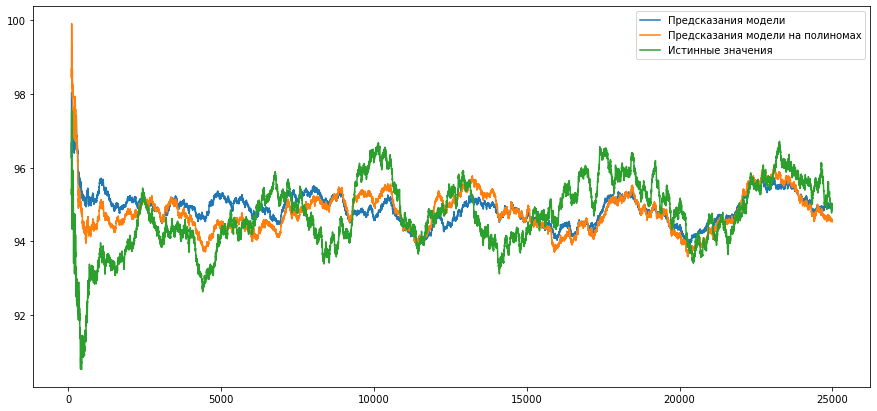

In [62]:
pd.Series(predictions).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Предсказания модели")
pd.Series(predictions_poly_3).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Предсказания модели на полиномах")
target_valid_3.reset_index(drop=True).rolling(2000, min_periods = 100).mean().plot(figsize = (15, 7), label = "Истинные значения")
plt.legend(loc="best")


Видим, что предсказания на полиномах лежат ближе к истинным значениям

### Сохраним предсказания и правильные ответы на валидационной выборке

In [63]:
region_3_data = pd.DataFrame([])
region_3_data["target"] = target_valid_3
region_3_data["predict"] = predictions_poly_3
region_3_data.head()

,target,predict
71747,97.651721,85.954746
80489,66.640660,100.511115
2655,57.776581,100.313751
71170,35.055066,72.607931
91137,82.047594,64.900496


### Промежуточные выводы:
* Точность предсказаний в различных регионах не однакова
* Наибольшая точность предсказаний наблюдается в регионе 2
* Наибольшие средние запасы сырья находятся в регионе 3

# 3. Подготовка к расчёту прибыли

## 3.1 Ключевые значения для расчётов

In [64]:
BUDGET = 10000000000 # Бюджет проекта
PRICE_WELL = 50000000 # Стоимость строительства одной скважины
PROFIT_PER_BARREL = 4500 # Прибыль с одной скважины
SAMPLE_MAX = 500 # При разведке региона проводится исследование 500 точек
SAMPLE_MIN = BUDGET/PRICE_WELL # Количество скважин на разработку которых хватает бюджета

## 3.2 Минимальный средний объём сырья в месторождениях региона, достаточный для его разработки

Минимальный средний объём сырья в регионе должен покрыть затраты на строительство всех скважин

In [65]:
print("Всего мы можем построить ", int(BUDGET/PRICE_WELL), "скважин")

Всего мы можем построить  200 скважин


Каждая скважина должна окупиться. Продажа одного барреля нефти приносит 4500 рублей. Рассчитаем точку окупаемости скважины.

In [66]:
min_mean_volum = PRICE_WELL/PROFIT_PER_BARREL
print(min_mean_volum) 

11111.111111111111


Т.е. что бы данный инвестиционный проект окупился и начал приносить прибыль инвесторам, средние запасы с 200 скважин должны быть более 11111 баррелей. И только продажа 11112 барреля начнет приносить прибыль. Понятно, что какие-то скважины могут иметь меньшие запасы нефти. Но нам важно, чтобы проект окупился в целом, поэтому мы считаем средний показатель запасов в 200 скважинах. 

## 3.3. Напишите функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели

In [67]:
def field_profit(target, predict):
    profit = (target[predict.index].sum() * 1000 * PROFIT_PER_BARREL) - BUDGET
    return profit

# 4. Расчёт прибыли и рисков 

## 4.1 Расчёт прибыли и рисков для региона 1

### 4.1.1 Применение техники Bootstrap с 1000 выборками, чтобы найти распределение прибыли

1000 раз случайным образом отберем 500 скважин. Отсортируем из них 200 лучших скважин и уже на их основе построим распределение средней прибыли проекта.

In [68]:
predictions_Bootstrap = []
state = np.random.RandomState(12345)
for i in range(1000):
    subsample = pd.Series(region_1_data["predict"].sample(SAMPLE_MAX, replace=True, random_state = state).sort_values(ascending = False).head(200))
    predictions_Bootstrap.append(field_profit(region_1_data["target"], subsample))

predictions_Bootstrap = pd.Series(predictions_Bootstrap)

Построим график распределения прибыли

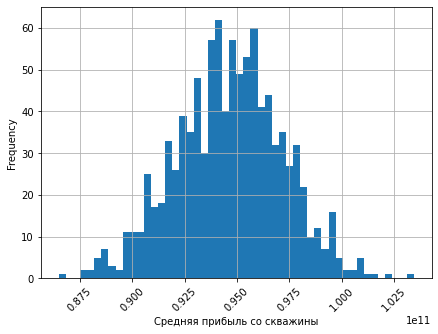

In [69]:
predictions_Bootstrap.plot(kind = "hist", bins = 50, rot = 45, grid = True, figsize = (7, 5))
plt.xlabel('Средняя прибыль со скважины')
plt.show()

### 4.1.2 Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [70]:
print("Средняя прибыль 200 самых прибыльных из 500 случайных скважин = ", int(predictions_Bootstrap.mean()/200), "рублей")
print("Средняя прибыль проекта в целом = ", int(predictions_Bootstrap.mean()), "рублей")

Средняя прибыль 200 самых прибыльных из 500 случайных скважин =  473219816 рублей
Средняя прибыль проекта в целом =  94643963299 рублей


Процедурой бутстреп найдем 95%-й доверительный интервал для прибыли проекта 

In [71]:
lower = predictions_Bootstrap.quantile(0.025)
upper = predictions_Bootstrap.quantile(0.975)
print(lower)
print(upper)

89633284422.13733
99513485766.76068


In [72]:
print("С вероятнстью 95% средняя прибыль проекта 200 самых прибыльных из 500 случайных скважин попадает в интервал от {:.2f} млрд. руб. до {:.2f} млрд. руб. Ширина доверительного интервала - {:.2f} млрд. руб.".format(lower/1000000000, upper/1000000000, (upper - lower)/1000000000))

С вероятнстью 95% средняя прибыль проекта 200 самых прибыльных из 500 случайных скважин попадает в интервал от 89.63 млрд. руб. до 99.51 млрд. руб. Ширина доверительного интервала - 9.88 млрд. руб.


Оценим риск убытков по каждой скважине. Риск убытков проекта определяется долей отрицательных значений прибыли проекта. Определим есть ли такие значения и какова их доля.

In [73]:
print("Количество отрицательных значений прибыли проекта =",(predictions_Bootstrap[predictions_Bootstrap < 0]).count())

Количество отрицательных значений прибыли проекта = 0


Вывод: риск убытков равен 0

## 4.2 Расчёт прибыли и рисков для региона 2

### 4.2.1 Применение техники Bootstrap с 1000 выборками, чтобы найти распределение прибыли

1000 раз случайным образом отберем 500 скважин. Отсортируем из них 200 лучших скважин и уже на их основе построим распределение средней прибыли проекта.

In [74]:
predictions_Bootstrap = []
state = np.random.RandomState(12345)
for i in range(1000):
    subsample = pd.Series(region_2_data["predict"].sample(500, replace=True, random_state = state).sort_values(ascending = False).head(200))
    predictions_Bootstrap.append(field_profit(region_2_data["target"], subsample))

predictions_Bootstrap = pd.Series(predictions_Bootstrap)

Построим график распределения прибыли

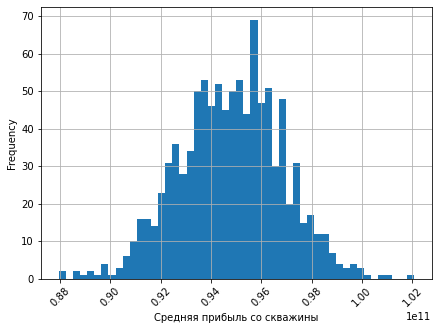

In [75]:
predictions_Bootstrap.plot(kind = "hist", bins = 50, rot = 45, grid = True, figsize = (7, 5))
plt.xlabel('Средняя прибыль со скважины')
plt.show()

### 4.2.2 Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [76]:
print("Средняя прибыль 200 самых прибыльных из 500 случайных скважин = ", int(predictions_Bootstrap.mean()/200), "рублей")
print("Средняя прибыль проекта в целом = ", int(predictions_Bootstrap.mean()), "рублей")

Средняя прибыль 200 самых прибыльных из 500 случайных скважин =  473924318 рублей
Средняя прибыль проекта в целом =  94784863701 рублей


Процедурой бутстреп найдем 95%-й доверительный интервал для прибыли проекта 

In [77]:
lower = predictions_Bootstrap.quantile(0.025)
upper = predictions_Bootstrap.quantile(0.975)
print(lower)
print(upper)

90895251249.72034
98666047454.6544


In [78]:
print("С вероятнстью 95% средняя прибыль проекта 200 самых прибыльных из 500 случайных скважин попадает в интервал от {:.2f} млрд. руб. до {:.2f} млрд. руб. Ширина доверительного интервала - {:.2f} млрд. руб.".format(lower/1000000000, upper/1000000000, (upper - lower)/1000000000))

С вероятнстью 95% средняя прибыль проекта 200 самых прибыльных из 500 случайных скважин попадает в интервал от 90.90 млрд. руб. до 98.67 млрд. руб. Ширина доверительного интервала - 7.77 млрд. руб.


Оценим риск убытков по каждой скважине. Риск убытков проекта определяется долей отрицательных значений прибыли проекта. Определим есть ли такие значения и какова их доля.

In [79]:
print("Количество отрицательных значений прибыли проекта =",(predictions_Bootstrap[predictions_Bootstrap < 0]).count())

Количество отрицательных значений прибыли проекта = 0


Вывод: риск убытков равен 0

## 4.3 Расчёт прибыли и рисков для региона 3

### 4.3.1 Применение техники Bootstrap с 1000 выборками, чтобы найти распределение прибыли

1000 раз случайным образом отберем 500 скважин. Отсортируем из них 200 лучших скважин и уже на их основе построим распределение средней прибыли проекта.

In [80]:
predictions_Bootstrap = []
state = np.random.RandomState(12345)
for i in range(1000):
    subsample = pd.Series(region_3_data["predict"].sample(500, replace=True, random_state = state).sort_values(ascending = False).head(200))
    predictions_Bootstrap.append(field_profit(region_3_data["target"], subsample))

predictions_Bootstrap = pd.Series(predictions_Bootstrap)

Построим график распределения прибыли

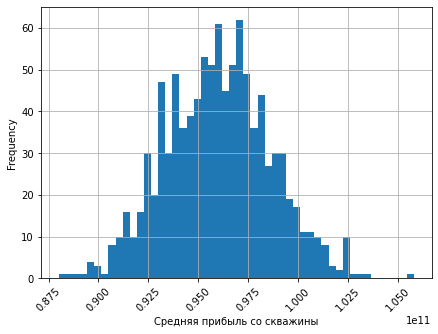

In [81]:
predictions_Bootstrap.plot(kind = "hist", bins = 50, rot = 45, grid = True, figsize = (7, 5))
plt.xlabel('Средняя прибыль со скважины')
plt.show()

### 4.3.2 Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [82]:
print("Средняя прибыль 200 самых прибыльных из 500 случайных скважин = ", int(predictions_Bootstrap.mean()/200), "рублей")
print("Средняя прибыль проекта в целом = ", int(predictions_Bootstrap.mean()), "рублей")

Средняя прибыль 200 самых прибыльных из 500 случайных скважин =  479999575 рублей
Средняя прибыль проекта в целом =  95999915174 рублей


Процедурой бутстреп найдем 95%-й доверительный интервал для прибыли проекта 

In [83]:
lower = predictions_Bootstrap.quantile(0.025)
upper = predictions_Bootstrap.quantile(0.975)
print(lower)
print(upper)

91021663999.4428
101364135074.1986


In [84]:
print("С вероятнстью 95% средняя прибыль проекта 200 самых прибыльных из 500 случайных скважин попадает в интервал от {:.2f} млрд. руб. до {:.2f} млрд. руб. Ширина доверительного интервала - {:.2f} млрд. руб.".format(lower/1000000000, upper/1000000000, (upper - lower)/1000000000))

С вероятнстью 95% средняя прибыль проекта 200 самых прибыльных из 500 случайных скважин попадает в интервал от 91.02 млрд. руб. до 101.36 млрд. руб. Ширина доверительного интервала - 10.34 млрд. руб.


Оценим риск убытков по каждой скважине. Риск убытков проекта определяется долей отрицательных значений прибыли проекта. Определим есть ли такие значения и какова их доля.

In [85]:
print("Количество отрицательных значений прибыли проекта =",(predictions_Bootstrap[predictions_Bootstrap < 0]).count())

Количество отрицательных значений прибыли проекта = 0


Вывод: риск убытков равен 0

## Вывод:
### Лучший регион для разработки месторождения - Регион 3. В данном регионе самая высока средняя прибыль проекта - 95,9 млрд. руб. А 95% доверительный интервал средней прибыли проекта начинается с 91 млрд. (самый высокий показатель из трех регионов). Риск убытков = 0